## Library Preparation

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## Data Preparation

In [37]:
def load(path, info=True, preview=True, summary=True):
    df = pd.read_csv(path)

    if info:
        print("✅ Data successfully imported!")
        print("• Rows:", df.shape[0], "| Columns:", df.shape[1])
        print("• Columns:", ", ".join(df.columns))

        print("\n📦 Data Types:")
        for dtype in ['object', 'int64', 'float64', 'bool']:
            cols = df.select_dtypes(dtype).columns
            if len(cols) > 0:
                print(f"→ {dtype} ({len(cols)}): {list(cols)}")

        missing_count = df.isnull().sum().sum()
        print("\n🚫 Missing Values:", "None ✅" if missing_count == 0 else f"{missing_count} missing values ❗")

    if summary:
        print("\n📊 Summary Statistics:")
        display(df.describe(include='all').transpose())

    if preview:
        print("\n🔍 First 5 Rows:")
        display(df.head())

    return df

ab = load("cookie_cats.csv")

✅ Data successfully imported!
• Rows: 90189 | Columns: 5
• Columns: userid, version, sum_gamerounds, retention_1, retention_7

📦 Data Types:
→ object (1): ['version']
→ int64 (2): ['userid', 'sum_gamerounds']
→ bool (2): ['retention_1', 'retention_7']

🚫 Missing Values: None ✅

📊 Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userid,90189.0000,NaN,NaN,NaN,4998412.2345,2883285.6077,116.0000,2512230.0000,4995815.0000,7496452.0000,9999861.0000
version,90189,2,gate_40,45489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_gamerounds,90189.0000,NaN,NaN,NaN,51.8725,195.0509,0.0000,5.0000,16.0000,51.0000,49854.0000
retention_1,90189,2,False,50036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retention_7,90189,2,False,73408,NaN,NaN,NaN,NaN,NaN,NaN,NaN



🔍 First 5 Rows:


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Summary Stats

In [22]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


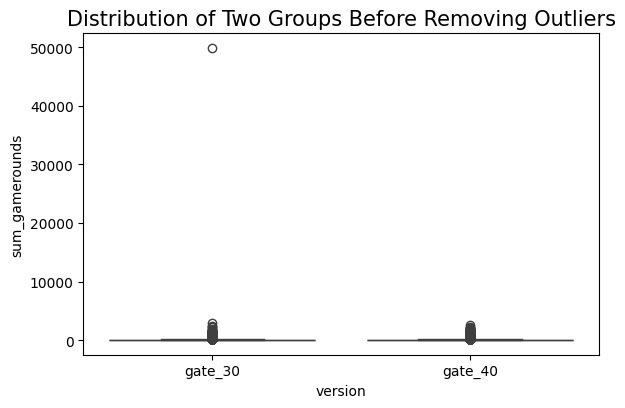

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxplot(x=ab["version"], y=ab["sum_gamerounds"], ax=ax)
ax.set_title("Distribution of Two Groups Before Removing Outliers", fontsize=15)
plt.tight_layout(pad=4)
plt.show()

## Removing Outliers

In [24]:
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


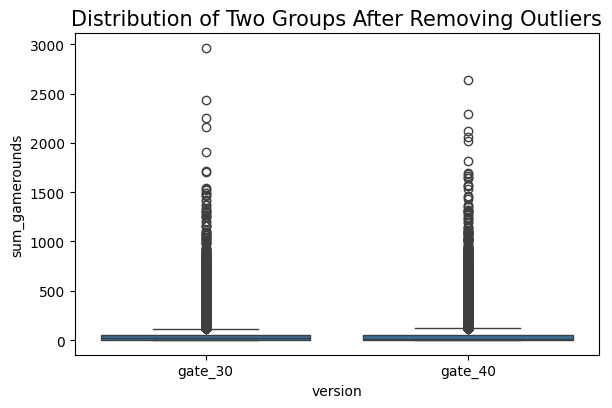

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.boxplot(x=ab["version"], y=ab["sum_gamerounds"], ax=ax)
ax.set_title("Distribution of Two Groups After Removing Outliers", fontsize=15)
plt.tight_layout(pad=4)
plt.show()

## A/B Test

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

def describe_group(x):
    return {
        "count": len(x),
        "mean": round(np.mean(x), 2),
        "std": round(np.std(x), 2),
        "median": round(np.median(x), 2),
        "min": x.min(),
        "max": x.max()
    }

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.std(x, ddof=1)**2 + (ny - 1)*np.std(y, ddof=1)**2) / (nx + ny - 2))
    return round((np.mean(x) - np.mean(y)) / pooled_std, 4)

def AB_Test_Advanced(dataframe, group, target):
    # Validasi kolom
    if group not in dataframe.columns or target not in dataframe.columns:
        raise ValueError("Kolom group/target tidak ditemukan di DataFrame.")

    if dataframe[group].nunique() != 2:
        raise ValueError("Data tidak terdiri dari 2 grup unik.")

    # Pisahkan data
    groups = dataframe[group].unique()
    groupA = dataframe[dataframe[group] == groups[0]][target].dropna()
    groupB = dataframe[dataframe[group] == groups[1]][target].dropna()

    # Descriptive Statistics
    print("📊 Descriptive Statistics")
    print(f"{groups[0]}:", describe_group(groupA))
    print(f"{groups[1]}:", describe_group(groupB))

    # Normality Test (Shapiro-Wilk) with sample if n > 5000
    sampleA = groupA.sample(min(len(groupA), 5000), random_state=42)
    sampleB = groupB.sample(min(len(groupB), 5000), random_state=42)
    ntA = shapiro(sampleA).pvalue < 0.05
    ntB = shapiro(sampleB).pvalue < 0.05

    # Uji Statistik
    if not ntA and not ntB:
        # Parametric Test
        levene_p = levene(groupA, groupB).pvalue
        if levene_p > 0.05:
            pval = ttest_ind(groupA, groupB, equal_var=True).pvalue
            homogeneity = "Yes"
        else:
            pval = ttest_ind(groupA, groupB, equal_var=False).pvalue
            homogeneity = "No"
        test_type = "Parametric"
    else:
        # Non-Parametric
        pval = mannwhitneyu(groupA, groupB).pvalue
        test_type = "Non-Parametric"
        homogeneity = "-"

    # Result Summary
    result = pd.DataFrame({
        "Test Type": [test_type],
        "Homogeneity": [homogeneity],
        "p-value": [round(pval, 5)],
        "Effect Size (Cohen's d)": [cohens_d(groupA, groupB)],
        "AB Hypothesis": ["Reject H0" if pval < 0.05 else "Fail to Reject H0"],
        "Comment": ["A/B groups are not similar!" if pval < 0.05 else "A/B groups are similar!"]
    })

    print("\n📌 A/B Test Hypothesis:")
    print("H0: Mean A == Mean B")
    print("H1: Mean A != Mean B\n")

    return result

AB_Test_Advanced(dataframe=ab, group="version", target="sum_gamerounds")

📊 Descriptive Statistics
gate_30: {'count': 44700, 'mean': np.float64(52.46), 'std': 256.71, 'median': np.float64(17.0), 'min': 0, 'max': 49854}
gate_40: {'count': 45489, 'mean': np.float64(51.3), 'std': 103.29, 'median': np.float64(16.0), 'min': 0, 'max': 2640}

📌 A/B Test Hypothesis:
H0: Mean A == Mean B
H1: Mean A != Mean B



,Test Type,Homogeneity,p-value,Effect Size (Cohen's d),AB Hypothesis,Comment
0,Non-Parametric,-,0.0502,0.0059,Fail to Reject H0,A/B groups are similar!
